# Comparing Collaborative filtering based recommender and Hybrid (collaborative plus content) recommender system

In [1]:
%run tweets_classes.ipynb

In [2]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

This project will compare collaborative filtering-based recommender and hybrid recommender systems. To build the collaborative filtering-based recommender, it is essential to use the Matrix Factorization technique, and Embedding layer from the PyTorch package to build the hybrid recommender.

## 1. Data

* u.item: Information about the items (movies); this is a tab-separated list of movie id | movie title | release date | video release date |IMDb URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western | The last 19 fields are the genres. A 1 indicates the movie is of that genre, a 0 indicates it is not; movies can be in several genres at once. The movie ids are the ones used in the u.data data set.


In [3]:
m_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation','Children','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-noir','Horror','Musical','Mystery','Romance','sci_fi','Thriller','War','Western']

movies_info = pd.read_csv('u.item', sep='|', names=m_cols, encoding='latin-1')
movies_info.head()


,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


* u.data: The full 'u' data set, 100000 ratings by 943 users on 1682 items. Each user has rated at least 20 movies. Users and items are numbered consecutively from 1. The data is randomly ordered. This is a tab- separated list of user id | item id | rating | timestamp. The timestamps are Unix seconds since 1/1/1970 UTC


In [4]:
m_cols = ['user_id','item_id','rating','timestamp']
ratings = pd.read_csv('u.data', sep='\t',names = m_cols)

In [5]:
ratings.head()


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


* u.genre -- A list of the genres.

In [6]:
m_cols = ['genre','id']
genres =  pd.read_csv('u.genre', sep='|',names = m_cols)

In [7]:
genres.head()

,genre,id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


## 2. Tweets from twitter: 
Given the u.item dataset, extract a tagword using the movie name. Then, search Twitter using that tagword to download related tweets for that movie. Do the same for each movie. Clean the tweets, and then calculate the sentiment score for each tweet for each movie. Calculate the average sentiment score for each movie and save the average as the sentiment score for that movie.

### 2.1 extracting the tagword from the movie name 

In [9]:
def get_tag_word(s): 
    t = re.sub(r"(\(.*?\))", '', s)
    t = t.replace(" ", "")
    return t
movies_info['keyword'] = movies_info['movie_title'].apply(lambda s: get_tag_word(s))
movies_info.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western,keyword
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,ToyStory
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,GoldenEye
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,FourRooms
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,GetShorty
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Copycat


### 2.2 Extracting tweets
to extract the information, we used the snscrape package. We built a class called "Scraper" that contains the necessary functions to do the scraping. All the extracted information will be stored in csv files, so they can be later called by a pandas dataframe.

In [10]:

date = datetime.datetime(2022, 6, 16)
# Here we generates a list of the last 60 days before 6/16/2022
dates = [ date + datetime.timedelta(days = i) for i in range(-60, 0) ]
# We define a fixed query variable to make the extraction
fixed_query = ''
# The following list builds a list of the relevant keywords for searching
keywords = list(movies_info['keyword'])


In [56]:
# The following block loops over each keyword to make the extraction. It creates a csv file for each keyword, 
# and extracts a maximum of 100 tweets for each keyword
'''
for keyword in keywords:
    scrapper = Scrapper(keyword, dates, fixed_query, 100)
    if scrapper.check_file_existence():
        # If the file already exists ommits the query to twitter API
        print(f'File {scrapper.file_name()} already exists.. skipping data extraction')
        continue
    # Gets tweet for each date
    scrapper.get_tweets()
    # Saves the file
    scrapper.save()   
'''




"\nfor keyword in keywords:\n    scrapper = Scrapper(keyword, dates, fixed_query, 100)\n    if scrapper.check_file_existence():\n        # If the file already exists ommits the query to twitter API\n        print(f'File {scrapper.file_name()} already exists.. skipping data extraction')\n        continue\n    # Gets tweet for each date\n    scrapper.get_tweets()\n    # Saves the file\n    scrapper.save()   \n"

In [12]:
'''
# Reads the tweet csv files and consolidates them in a single dataframe
complete_df = pd.DataFrame() 
for keyword in keywords:
    scrapper = Scrapper(keyword)
    # Loads the data from its corresponding CSV file
    scrapper.load()
    # Merges the data in a single dataframe
    complete_df = pd.concat([complete_df, scrapper.dataframe])
complete_df.to_csv('./data/complete_input.csv')


'''





"\n# Reads the tweet csv files and consolidates them in a single dataframe\ncomplete_df = pd.DataFrame() \nfor keyword in keywords:\n    scrapper = Scrapper(keyword)\n    # Loads the data from its corresponding CSV file\n    scrapper.load()\n    # Merges the data in a single dataframe\n    complete_df = pd.concat([complete_df, scrapper.dataframe])\ncomplete_df.to_csv('./data/complete_input.csv')\n\n\n"

In [13]:
# here we load the csv file to a dataframe
tweets = pd.read_csv('./data/complete_input.csv')
# Here is a sample of the dataset
tweets.head()

,Unnamed: 0.1,Unnamed: 0,id,url,date,content,keyword
0,0,0,1515818269026013185,https://twitter.com/OramaStore/status/15158182...,2022-04-17 22:23:32+00:00,#love #toystory #trendy #onlineshop Green Toys...,#ToyStory
1,1,1,1515816410261430281,https://twitter.com/ComeOnMimi/status/15158164...,2022-04-17 22:16:09+00:00,@lolaindigoarg @Los40 @Del40al1_es Voto por #T...,#ToyStory
2,2,2,1515810680615710730,https://twitter.com/CDSXCalibur/status/1515810...,2022-04-17 21:53:23+00:00,Trying to be #Patient when coming to #Walmart ...,#ToyStory
3,3,3,1515808758080978950,https://twitter.com/cstephens2/status/15158087...,2022-04-17 21:45:44+00:00,Jessie was absolutely enthralled by her mini-m...,#ToyStory
4,4,4,1515797388304302083,https://twitter.com/lolaindigogrn/status/15157...,2022-04-17 21:00:34+00:00,@lolaindigoarg @entreotroscien @Los40 @Del40al...,#ToyStory


<AxesSubplot:xlabel='num', ylabel='num_tweets'>

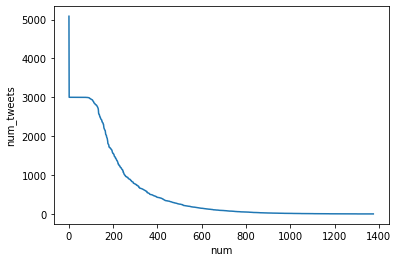

In [153]:
num_tweets = list(tweets['keyword'].value_counts())
num_tweets_df = pd.DataFrame(num_tweets,columns = ['num_tweets'])
num_tweets_df['num'] =  num_tweets_df.index

sns.lineplot(data=num_tweets_df, x="num", y="num_tweets")

### 2.3 Data cleaning
We created a class called Cleaner which has the necessary methods to clean the text:
* drop_duplicates() method: Drops all the duplicated tweets on the dataset
* extract_content() method: This method clean the text using the following: 
      * Remove emojis
      * Remove URLs
      * Remove Numbers and non alhpa characters
      * Remove punctuation
      * Remove stop words
      * Tokenization
After this steps we can obtain a new tokenized text column called: content_clean

In [14]:
# Here we convert the date column to datetime, and also create a create an additional column with yyyy-mm-dd format.
tweets['datetime'] = pd.to_datetime(tweets['date'])
tweets['date'] = tweets['datetime'].dt.normalize().dt.strftime('%Y-%m-%d')

In [15]:
# Here we create the cleaner object and execute the clean functions

cleaner = Cleaner(tweets, ['date','content','keyword'])
cleaner.drop_duplicates()
cleaner.extract_content()
cleaner.extract_hashtags()
cleaner.extract_usernames()

In [16]:
# Here is a sample of the result dataset:
clean_tweets = cleaner.get_result()
clean_tweets = clean_tweets.reset_index()
clean_tweets

,index,date,content,keyword,content_clean,hashtags,usernames
0,0,2022-04-17,#love #toystory #trendy #onlineshop Green Toys...,#ToyStory,"[love, toystory, trendy, onlineshop, green, to...","[love, toystory, trendy, onlineshop]",[]
1,1,2022-04-17,@lolaindigoarg @Los40 @Del40al1_es Voto por #T...,#ToyStory,"[lolaindigoarg, los, del, es, voto, por, toyst...","[ToyStory, Del40al1CocaCola, Mivoto40LolaIndigo]","[lolaindigoarg, Los40, Del40al1_es, Los40, Del..."
2,2,2022-04-17,Trying to be #Patient when coming to #Walmart ...,#ToyStory,"[trying, patient, coming, walmart, girl, neede...","[Patient, Walmart, patience, humility, empathy...",[]
3,3,2022-04-17,Jessie was absolutely enthralled by her mini-m...,#ToyStory,"[jessie, absolutely, enthralled, mini, pixarpi...","[pixarpier, toystory, disneycaliforniaadventur...",[]
4,4,2022-04-17,@lolaindigoarg @entreotroscien @Los40 @Del40al...,#ToyStory,"[lolaindigoarg, entreotroscien, los, del, es, ...","[ToyStory, Del40al1CocaCola, Mivoto40LolaIndigo]","[lolaindigoarg, entreotroscien, Los40, Del40al..."
...,...,...,...,...,...,...,...
757833,784133,2022-05-01,didn't know martin was this funny #yousocrazy,#YouSoCrazy,"[know, martin, funny, yousocrazy]",[yousocrazy],[]
757834,784134,2022-05-10,"#YouSoCrazy, Know where there is a 64 Chevelle...",#YouSoCrazy,"[yousocrazy, know, chevelle, speed, power, win...","[YouSoCrazy,, USA, SgtHeiligUSMC]",[jeffdunham]
757835,784135,2022-05-14,#YouSoCrazy Remember the Clipper Chip I spok...,#YouSoCrazy,"[yousocrazy, remember, clipper, chip, spoke, c...","[YouSoCrazy, ThatWasp, USA, USMC]",[elonmusk]
757836,784136,2022-05-18,@DAJustAsking @original1ny @Road25th @MrChaseb...,#YouSoCrazy,"[dajustasking, original, road, mrchasebooth, r...",[YouSoCrazy],"[DAJustAsking, original1ny, Road25th, MrChaseb..."


### 2.4 Sentiment Analysis with vaderSentiment
In this section we perform the sentiment analysis with the text of each twitter. A positive, neutral, and negative sentiment will be assigned to each tweet. The vaderSentiment library will be used to calculate the sentiment. This package returns a value between -1 and 1 to refer to the sentiment.

In [17]:

# We create an instance of the class and calculate the sentiment
sentiment = SentimentAnalyzer(clean_tweets)
sentiment.get_sentiments()
tweets_with_sentiment = sentiment.get_result()

# Here we see the results in a new column
tweets_with_sentiment

,index,date,content,keyword,content_clean,hashtags,usernames,sentiment_score,sentiment
0,0,2022-04-17,#love #toystory #trendy #onlineshop Green Toys...,#ToyStory,"[love, toystory, trendy, onlineshop, green, to...","[love, toystory, trendy, onlineshop]",[],0.6369,positive
1,1,2022-04-17,@lolaindigoarg @Los40 @Del40al1_es Voto por #T...,#ToyStory,"[lolaindigoarg, los, del, es, voto, por, toyst...","[ToyStory, Del40al1CocaCola, Mivoto40LolaIndigo]","[lolaindigoarg, Los40, Del40al1_es, Los40, Del...",0.0000,neutral
2,2,2022-04-17,Trying to be #Patient when coming to #Walmart ...,#ToyStory,"[trying, patient, coming, walmart, girl, neede...","[Patient, Walmart, patience, humility, empathy...",[],0.9861,positive
3,3,2022-04-17,Jessie was absolutely enthralled by her mini-m...,#ToyStory,"[jessie, absolutely, enthralled, mini, pixarpi...","[pixarpier, toystory, disneycaliforniaadventur...",[],0.0000,neutral
4,4,2022-04-17,@lolaindigoarg @entreotroscien @Los40 @Del40al...,#ToyStory,"[lolaindigoarg, entreotroscien, los, del, es, ...","[ToyStory, Del40al1CocaCola, Mivoto40LolaIndigo]","[lolaindigoarg, entreotroscien, Los40, Del40al...",0.0000,neutral
...,...,...,...,...,...,...,...,...,...
757833,784133,2022-05-01,didn't know martin was this funny #yousocrazy,#YouSoCrazy,"[know, martin, funny, yousocrazy]",[yousocrazy],[],0.5228,positive
757834,784134,2022-05-10,"#YouSoCrazy, Know where there is a 64 Chevelle...",#YouSoCrazy,"[yousocrazy, know, chevelle, speed, power, win...","[YouSoCrazy,, USA, SgtHeiligUSMC]",[jeffdunham],0.8453,positive
757835,784135,2022-05-14,#YouSoCrazy Remember the Clipper Chip I spok...,#YouSoCrazy,"[yousocrazy, remember, clipper, chip, spoke, c...","[YouSoCrazy, ThatWasp, USA, USMC]",[elonmusk],-0.6734,negative
757836,784136,2022-05-18,@DAJustAsking @original1ny @Road25th @MrChaseb...,#YouSoCrazy,"[dajustasking, original, road, mrchasebooth, r...",[YouSoCrazy],"[DAJustAsking, original1ny, Road25th, MrChaseb...",0.0000,neutral


In [18]:
sentiment.mean_sentiment_by_keyword()
mean_sentiments = sentiment.get_result()

In [19]:
mean_sentiments

,keyword,sentiment_score
0,#'TilThereWasYou,0.000000
1,#1-900,0.057174
2,#101Dalmatians,0.259444
3,#12AngryMen,0.073759
4,#187,-0.048073
...,...,...
1371,#YoungFrankenstein,0.284343
1372,#YoungGuns,0.284644
1373,#YoungGunsII,-0.065944
1374,#ZeusandRoxanne,0.000000


## 3.0 Matrix Factorization

In a recommendation engine like Netflix or MovieLens, there is a user base and a catalogue of products (movies for the above two systems). Given that every user has given some products in the system a rating, we would want to estimate how they would rate the goods they have not yet given a rating for so that we may provide them suggestions. In this instance, a matrix may be used to represent all the data we know about the current ratings.

In [20]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


The rationale for utilising matrix factorization to address this issue is that there ought to be some latent characteristics that affect how a user evaluates a product. For instance, if two users share a preference for action movies, they could both give a certain movie high ratings if they enjoy the stars or actresses in it. Because the attributes connected with the user and the object should correspond, if we can uncover these latent traits, we should be able to predict a rating with regard to a certain user and an item.
In our quest to identify the various features, we also operate under the presumption that there are fewer features overall than there are users and items. Given that it would be illogical to assume that each user is connected to a specific feature, this assumption should not be difficult to grasp (although this is not impossible). In any event, there would be no use in offering suggestions if this were the case because none of these people would be interested in the things that other users have rated. The same justification also holds true for the products.

### 3.2 Python implementation

### 3.1 Math behind Matrix Factorization
Firstly, we have a set U of users, and a set D of items. Let R of size |U| X |D| be the matrix that contains all the ratings that the users have assigned to the items. Also, we assume that we would like to discover K latent features. Our task, then, is to find two matrics matrices P (a |U| X K matrix) and Q (a |D| X K matrix) such that their product approximates R

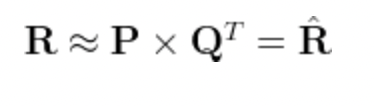

We now need to figure out how to get P and Q. One method of solving this issue is to initialise the two matrices with certain values, determine how "different" the products of the two are from "mathbf M," and then attempt to reduce this difference repeatedly. This approach, known as gradient descent, seeks to identify a local minimum of the difference.
The following equation may be used to determine this difference, which is typically referred to as the error between the estimated rating and the true rating, for each user-item pair:

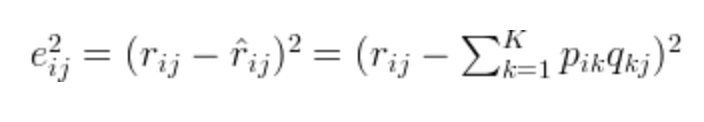

Knowing which way to change the values of p and q will help us reduce mistake. To differentiate the aforementioned equation with regard to these two variables independently, we state that we need to know the gradient at the present values:

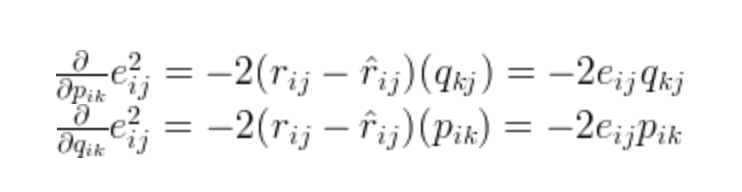

we can now create the update rules for both pik and qkj after obtaining the gradient:
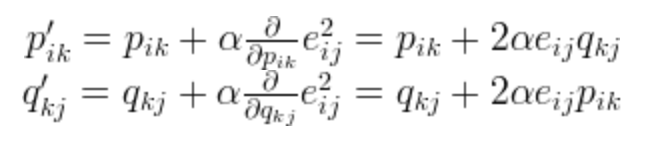

Here, α is a constant whose value determines the rate of approaching the minimum. Usually we will choose a small value for α, say 0.0002. This is because if we make too large a step towards the minimum we may run into the risk of missing the minimum and end up oscillating around the minimum.
The process can then be carried out again until the error converges to its minimum using the aforementioned updating rules. The following equation may be used to compute the total error and help us decide whether to halt the procedure.

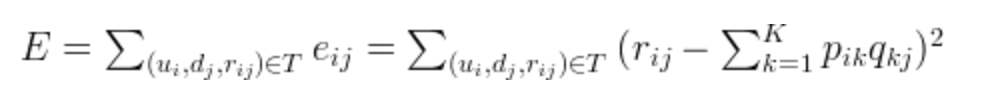

Regularization is a frequent addition to this fundamental approach to prevent overfitting. To do this, include the parameter beta and change the squared error as follows:

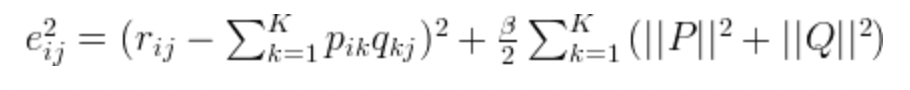

In [22]:
pivot_ratings = pd.pivot_table(ratings, index='user_id', columns='item_id', values='rating', fill_value=0)
pivot_ratings_numpy=np.array(pivot_ratings)
pivot_ratings

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
940,0,0,0,2,0,0,4,5,3,0,...,0,0,0,0,0,0,0,0,0,0
941,5,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
def matrix_factorization(R, P, Q, K, steps=20, alpha=0.002, beta=0.02):
    '''
    R: rating matrix
    P: |U| * K (User features matrix)
    Q: |D| * K (Item features matrix)
    K: latent features
    steps: iterations
    alpha: learning rate
    beta: regularization parameter'''
    Q = Q.T

    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    # calculate error
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])

                    for k in range(K):
                        # calculate gradient with a and beta parameter
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        eR = np.dot(P,Q)

        e = 0

        for i in range(len(R)):

            for j in range(len(R[i])):

                if R[i][j] > 0:

                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)

                    for k in range(K):

                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        # 0.001: local minimum
        if e < 0.001:

            break

    return P, Q.T

In [24]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
R = pivot_ratings_numpy
# N: num of User
N = len(pivot_ratings_numpy)
# M: num of Movie
M = len(pivot_ratings_numpy[0])
# Num of Features
ks = []
errors = []
for i in range(20,130,10):
    K = i
    print(K)
    P = np.random.rand(N,K)
    Q = np.random.rand(M,K)

    nP, nQ = matrix_factorization(R, P, Q, K)
    nR = np.dot(nP, nQ.T)
    error = np.sqrt(mean_squared_error(nR,pivot_ratings_numpy))
    ks.append(K)
    errors.append(error)


20
30
40
50
60
70
80
90
100
110
120


<AxesSubplot:xlabel='Ks', ylabel='Error'>

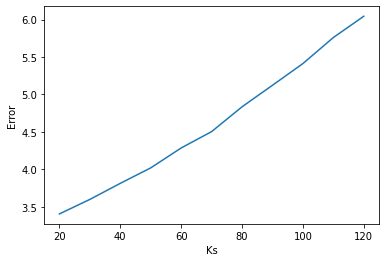

In [25]:
results_df = pd.DataFrame(list(zip(ks, errors)),
               columns =['Ks', 'Error'])
sns.lineplot(data=results_df, x="Ks", y="Error")

In [26]:
K = 20
print(K)
P = np.random.rand(N,K)
Q = np.random.rand(M,K)

nP, nQ = matrix_factorization(R, P, Q, K)
nR = np.dot(nP, nQ.T)
error = np.sqrt(mean_squared_error(nR,pivot_ratings_numpy))
ks.append(K)
errors.append(error)

20


In [27]:
nR_df=pd.DataFrame(nR, columns=list(pivot_ratings.columns)) 
nR_df.index = np.arange(1, len(nR_df)+1)
nR_df

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,3.616996,2.963831,3.326585,3.754140,3.418957,4.330297,3.892415,3.533426,3.982828,3.351841,...,4.676121,3.583495,3.948989,3.362200,4.037410,3.612734,3.513341,3.546838,3.482369,3.970251
2,4.298379,2.868976,2.701164,3.660110,3.095477,3.564496,3.837967,4.729861,4.009163,3.431204,...,4.649262,3.757017,3.557915,3.654415,4.145858,3.794853,4.060608,3.896859,3.890409,3.350946
3,3.290342,2.966917,2.680469,2.869546,3.058172,3.715889,2.951372,3.114282,3.343600,3.850182,...,4.447046,3.487314,3.740611,3.543431,4.335911,2.576442,2.677441,3.045307,2.895196,3.350302
4,4.754979,4.167042,4.838374,4.397663,3.973343,5.663634,5.143632,4.653015,4.699622,5.062110,...,6.117394,5.078841,5.159623,5.510108,5.389496,4.839339,4.648864,5.460669,4.772173,5.008031
5,3.396759,2.998294,3.186029,3.548988,2.304816,3.906060,3.502683,3.071041,3.014944,3.278627,...,3.168264,2.445623,3.512176,3.081718,3.236776,3.175784,3.691017,3.600380,2.650183,3.280333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,5.400106,4.596978,3.985532,4.533675,4.520587,5.502963,4.680064,4.903874,5.169748,5.180250,...,6.379576,4.536528,5.397179,5.368568,5.932550,4.323042,4.797668,5.287915,4.259699,4.800983
940,3.295775,3.048213,2.321961,2.950219,3.587393,3.180687,3.595794,3.936894,4.082267,3.003567,...,4.284681,3.128948,3.662372,3.893428,4.365055,3.455504,3.597137,3.818318,3.784680,3.345505
941,4.030036,4.059623,3.900036,3.879707,3.806160,4.438542,3.868405,3.749677,3.196083,4.103131,...,4.822988,4.012512,4.256368,4.569764,4.458057,4.044498,4.107297,4.523678,4.006940,3.885069
942,4.239117,3.979706,3.248716,3.716568,3.468952,4.699109,4.432243,4.513564,4.298124,4.585217,...,5.393907,4.454425,4.647179,4.443200,5.244945,3.358765,4.093373,4.252017,3.658192,4.110398


In [28]:
pivot_ratings

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
940,0,0,0,2,0,0,4,5,3,0,...,0,0,0,0,0,0,0,0,0,0
941,5,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[3.90215493 4.27128286 4.18044187 ... 4.32353662 5.50154678 4.20811479]


## 4. Hybrid Recommender System
Making a deep learning model for a hybrid recommendation system is the aim. 
We'll get a lot of help with it from embedding layers (basically a layer that maps an index to a vector of trainable weights).
The Neural Network that we implemented is the following: 

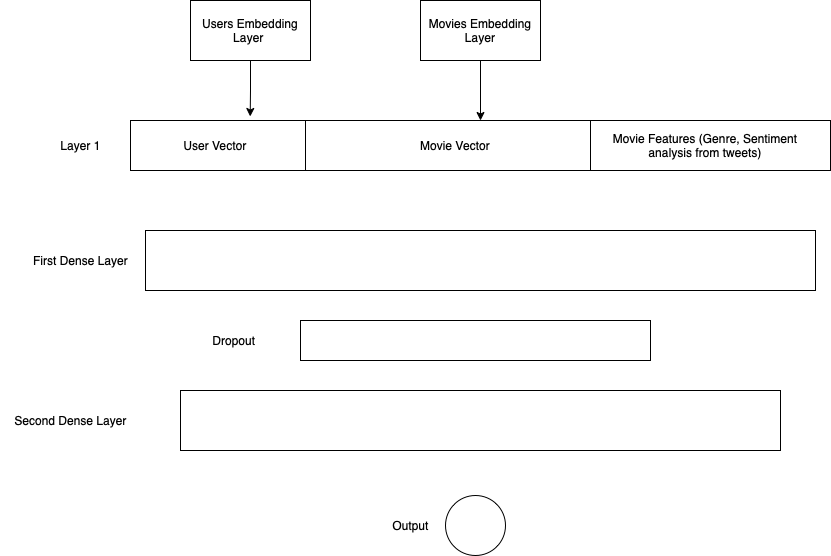

### 4.1 Data Preprocessing

In [29]:
movies_info.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western,keyword
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,ToyStory
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,GoldenEye
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,FourRooms
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,GetShorty
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Copycat


In [30]:
mean_sentiments['keyword']=mean_sentiments['keyword'].apply(lambda x: x.replace('#', ''))
mean_sentiments.head()

,keyword,sentiment_score
0,'TilThereWasYou,0.000000
1,1-900,0.057174
2,101Dalmatians,0.259444
3,12AngryMen,0.073759
4,187,-0.048073


Basically. What we need is to get a dataframe that contains all the features of the movies: Genre, Score from the users and the sentiment score that we got from the tweets. For that, we need to merge the movies_info, mean_sentiments and ratings dataframe

In [31]:
movies_info = movies_info.merge(mean_sentiments, on='keyword', how='left')

In [32]:
movies_info

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western,keyword,sentiment_score
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,ToyStory,0.172849
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,1,0,0,GoldenEye,0.236044
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,FourRooms,0.118717
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,GetShorty,0.077233
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,1,0,0,Copycat,0.144983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Mat'isyn,0.253600
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,1,0,1,0,0,B.Monkey,-0.043922
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,1,0,0,0,0,SlidingDoors,0.351519
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,YouSoCrazy,-0.036957


In [33]:
ratings = ratings.rename(columns={'item_id': 'movie_id'})
ratings

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [34]:
movies_info

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western,keyword,sentiment_score
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,ToyStory,0.172849
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,1,0,0,GoldenEye,0.236044
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,FourRooms,0.118717
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,GetShorty,0.077233
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,1,0,0,Copycat,0.144983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Mat'isyn,0.253600
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,1,0,1,0,0,B.Monkey,-0.043922
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,1,0,0,0,0,SlidingDoors,0.351519
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,YouSoCrazy,-0.036957


In [35]:
#movies_info=movies_info.drop('_merge',axis = 1)
full_df2 = movies_info.merge(ratings, on='movie_id', how='left')
full_df2

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Romance,sci_fi,Thriller,War,Western,keyword,sentiment_score,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,ToyStory,0.172849,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,ToyStory,0.172849,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,ToyStory,0.172849,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,ToyStory,0.172849,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,ToyStory,0.172849,66,3,883601324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,Mat'isyn,0.253600,863,1,889289570
99996,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,1,0,1,0,0,B.Monkey,-0.043922,863,3,889289491
99997,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,1,0,0,0,0,SlidingDoors,0.351519,863,2,889289570
99998,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,YouSoCrazy,-0.036957,896,3,887160722


In [36]:
full_df = ratings.merge(movies_info, on='movie_id', how='left')
full_df

,user_id,movie_id,rating,timestamp,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,...,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western,keyword,sentiment_score
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,Kolya,-0.015440
1,186,302,3,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,0,0,1,0,0,1,0,0,L.A.Confidential,0.161026
2,22,377,1,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,0,0,0,Heavyweights,0.103676
3,244,51,2,880606923,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,0,0,1,0,0,1,1,LegendsoftheFall,0.226147
4,166,346,1,886397596,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,0,0,JackieBrown,0.227223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)",14-Sep-1996,NaN,http://us.imdb.com/M/title-exact?First%20Wives...,0,0,...,0,0,0,0,0,0,0,0,"FirstWivesClub,The",0.425364
99996,716,204,5,879795543,Back to the Future (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Back%20to%20t...,0,0,...,0,0,0,0,1,0,0,0,BacktotheFuture,0.222046
99997,276,1090,1,874795795,Sliver (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Sliver%20(1993),0,0,...,0,0,0,0,0,1,0,0,Sliver,0.246469
99998,13,225,2,882399156,101 Dalmatians (1996),27-Nov-1996,NaN,http://us.imdb.com/M/title-exact?101%20Dalmati...,0,0,...,0,0,0,0,0,0,0,0,101Dalmatians,0.259444


In [37]:
full_df["sentiment_score"].fillna("0", inplace = True)

In [38]:
full_df = full_df.drop(['keyword'], axis=1)
full_df

,user_id,movie_id,rating,timestamp,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,...,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western,sentiment_score
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,-0.01544
1,186,302,3,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,1,0,0,1,0,0,1,0,0,0.161026
2,22,377,1,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,0,0,0,0,0,0.103676
3,244,51,2,880606923,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,0,0,0,1,0,0,1,1,0.226147
4,166,346,1,886397596,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,0,0,0,0.227223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)",14-Sep-1996,NaN,http://us.imdb.com/M/title-exact?First%20Wives...,0,0,...,0,0,0,0,0,0,0,0,0,0.425364
99996,716,204,5,879795543,Back to the Future (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Back%20to%20t...,0,0,...,0,0,0,0,0,1,0,0,0,0.222046
99997,276,1090,1,874795795,Sliver (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Sliver%20(1993),0,0,...,0,0,0,0,0,0,1,0,0,0.246469
99998,13,225,2,882399156,101 Dalmatians (1996),27-Nov-1996,NaN,http://us.imdb.com/M/title-exact?101%20Dalmati...,0,0,...,0,0,0,0,0,0,0,0,0,0.259444


In [39]:
full_df.sort_values('movie_id')

,user_id,movie_id,rating,timestamp,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,...,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western,sentiment_score
25741,84,1,2,883452108,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,...,0,0,0,0,0,0,0,0,0,0.172849
93639,806,1,4,882385082,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,...,0,0,0,0,0,0,0,0,0,0.172849
55726,768,1,5,883835025,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,...,0,0,0,0,0,0,0,0,0,0.172849
49529,92,1,4,875810511,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,...,0,0,0,0,0,0,0,0,0,0.172849
89079,419,1,4,879435590,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,...,0,0,0,0,0,0,0,0,0,0.172849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75323,863,1678,1,889289570,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,...,0,0,0,0,0,0,0,0,0,0.2536
67302,863,1679,3,889289491,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,...,0,0,0,0,1,0,1,0,0,-0.043922
80394,863,1680,2,889289570,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,...,0,0,0,0,1,0,0,0,0,0.351519
92329,896,1681,3,887160722,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,...,0,0,0,0,0,0,0,0,0,-0.036957


After dropping all the unnecesary features from the dataframes. we got the following dataframe

In [40]:
full_df_clean = full_df.drop(['timestamp','release_date','video_release_date','IMDb_URL','movie_title'], axis=1)
full_df_clean

,user_id,movie_id,rating,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western,sentiment_score
0,196,242,3,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.01544
1,186,302,3,0,0,0,0,0,0,1,...,1,0,0,1,0,0,1,0,0,0.161026
2,22,377,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0.103676
3,244,51,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0.226147
4,166,346,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.227223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.425364
99996,716,204,5,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0.222046
99997,276,1090,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.246469
99998,13,225,2,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0.259444


In [41]:
full_df_clean.columns

Index(['user_id', 'movie_id', 'rating', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'sci_fi', 'Thriller', 'War', 'Western', 'sentiment_score'],
      dtype='object')

In [42]:
full_df_clean = full_df_clean[['rating', 'user_id', 'movie_id', 'sentiment_score', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'sci_fi', 'Thriller', 'War', 'Western']]
full_df_clean

,rating,user_id,movie_id,sentiment_score,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western
0,3,196,242,-0.01544,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,186,302,0.161026,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,22,377,0.103676,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2,244,51,0.226147,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,1,166,346,0.227223,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,880,476,0.425364,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99996,5,716,204,0.222046,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
99997,1,276,1090,0.246469,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99998,2,13,225,0.259444,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Then. We split the data into train and validation using 70% for trainning purposes and 30% for validaiton 

In [43]:
train = full_df_clean.iloc[:70000]
validation = full_df_clean.iloc[70000:]

In [44]:
train

,rating,user_id,movie_id,sentiment_score,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western
0,3,196,242,-0.01544,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,186,302,0.161026,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,22,377,0.103676,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2,244,51,0.226147,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,1,166,346,0.227223,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,4,91,1192,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,2,788,174,0.157787,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,4,62,134,0.197007,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,3,699,762,0.543092,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
validation

,rating,user_id,movie_id,sentiment_score,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western
70000,5,338,517,0.177521,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
70001,3,290,234,0.165306,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
70002,3,458,762,0.543092,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70003,3,524,582,0.39034,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
70004,3,530,176,0.158534,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3,880,476,0.425364,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99996,5,716,204,0.222046,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
99997,1,276,1090,0.246469,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99998,2,13,225,0.259444,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [46]:
train_np = train.to_numpy()
validation_np = validation.to_numpy()

In [47]:
train.head()

,rating,user_id,movie_id,sentiment_score,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western
0,3,196,242,-0.01544,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,186,302,0.161026,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,22,377,0.103676,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2,244,51,0.226147,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,1,166,346,0.227223,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4.2 Building the Neural Network


In [48]:
from torch import nn
import torch
from torch.nn  import functional as F
import torch.optim as  optim 
if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("gpu up")
else:  
    dev = "cpu" 
    device = torch.device(dev)

In [49]:
movies_info['movie_id'].max()

1682

Builing the architecture of the neural network

In [61]:
class RecommendationNet(nn.Module):
    def __init__(self,latent_vector_size):
        super(RecommendationNet,self).__init__()
        self.l_v_s = latent_vector_size
        self.users = nn.Embedding(100000,self.l_v_s,sparse = True) 
        self.movies = nn.Embedding(1683,self.l_v_s,sparse = True)
        self.linear1 = nn.Linear(self.l_v_s+self.l_v_s+20,64)
        self.linear2 = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(64,32)
        self.linear4 = nn.Linear(32,1)
    def forward(self,x):
        user = x[:,0].long() # here am selecting the user and anime ids from the input 
        movie = x[:,1].long() 
        otherfeatures = x[:,2:]
        userVector = self.users(user)
        movieVector = self.movies(movie)
        layer1 = torch.cat((userVector,movieVector,otherfeatures),1)# concatenating vectors
        layer2 = F.relu(self.linear1(layer1))
        layer3 = F.relu(self.linear2(layer2))
        layer4 = F.relu(self.linear3(layer3))
        out = torch.sigmoid(self.linear4(layer4)) 
        return out 
myNN = RecommendationNet(90)
myNN.to(device)

RecommendationNet(
  (users): Embedding(100000, 90, sparse=True)
  (movies): Embedding(1683, 90, sparse=True)
  (linear1): Linear(in_features=200, out_features=64, bias=True)
  (linear2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=1, bias=True)
)

There are some hyperparameters to tunne to get a better model. Such as: the latent vector size and the number of epochs. To know that. We iterated with different latent vector size and we compared the errors 

In [57]:

optimizer = optim.Adagrad(myNN.parameters(),lr = 0.001)
train_np = train.to_numpy()
batch_size = 64

npData = train_np
npData[:,:1] = npData[:,:1]/10 
# traintrues = np.expm1(npData[:,4].reshape(-1,1)).reshape(-1)
def ceil(a,b):
    return -(-a//b)

n_samples = len(npData)
better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))

mses_v = []
vector_size = []
for j in range(20,130,10):
    myNN = RecommendationNet(j)
    myNN.to(device)
    for i in range(20):
    #     preds=[]
        for i in range(ceil(n_samples, better_batch_size)):
            batch = npData[i * better_batch_size: (i+1) * better_batch_size]
            batch = torch.Tensor(batch.astype(np.float32)).to(device)
            X = batch[:,1:]
            y = batch[:,:1]
            myNN.zero_grad()

            pred = myNN(X)
    #         preds.extend(np.expm1(pred.cpu().detach().numpy()).reshape(-1))
            err = F.mse_loss(pred,y)
            err.backward()
            optimizer.step()
        #print(torch.sqrt(err))
        valpreds = myNN(torch.Tensor(validation_np.astype(np.float32)[:,1:]).to(device)).cpu().detach().numpy().reshape(-1)
        mse = np.sqrt(mean_squared_error(validation.rating.to_numpy(),valpreds*10))
        #print("Validation Error: ",mse)
    mses_v.append(mse)
    vector_size.append(j)
    print(f'Vector Size: {j}, MSE: {mse}')

Vector Size: 20, MSE: 1.976364332129913
Vector Size: 30, MSE: 2.3021141542148724
Vector Size: 40, MSE: 1.894362206933756
Vector Size: 50, MSE: 1.9820599509868786
Vector Size: 60, MSE: 2.1441245624872933
Vector Size: 70, MSE: 1.6365418238330887
Vector Size: 80, MSE: 1.8262581067391939
Vector Size: 90, MSE: 1.837771105512226
Vector Size: 100, MSE: 1.7914811917198554
Vector Size: 110, MSE: 2.2853657857597196
Vector Size: 120, MSE: 1.7734247589703314


After the experiment, we concluded that the best vector size is 100

<AxesSubplot:xlabel='Vector_size', ylabel='mses'>

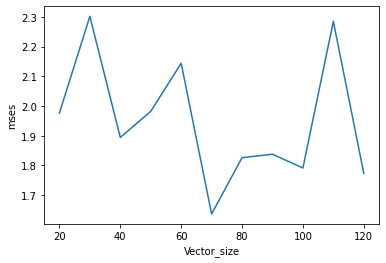

In [59]:
import seaborn as sns
results_df_NN = pd.DataFrame(list(zip(vector_size, mses_v)),
               columns =['Vector_size', 'mses'])
sns.lineplot(data=results_df_NN, x="Vector_size", y="mses")

Now, the same process for the epochs. 

In [64]:
optimizer = optim.Adagrad(myNN.parameters(),lr = 0.001)
train_np = train.to_numpy()
batch_size = 64

npData = train_np
npData[:,:1] = npData[:,:1]/10 
# traintrues = np.expm1(npData[:,4].reshape(-1,1)).reshape(-1)
def ceil(a,b):
    return -(-a//b)

n_samples = len(npData)
better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))
print(better_batch_size)
mses = []
epochs = []

myNN = RecommendationNet(70)
myNN.to(device)

for epoch in range(300):
#     preds=[]
    for i in range(ceil(n_samples, better_batch_size)):
        batch = npData[i * better_batch_size: (i+1) * better_batch_size]
        batch = torch.Tensor(batch.astype(np.float32)).to(device)
        X = batch[:,1:]
        y = batch[:,:1]
        myNN.zero_grad()

        pred = myNN(X)
        err = F.mse_loss(pred,y)
        err.backward()
        optimizer.step()
    #print(torch.sqrt(err))
    valpreds = myNN(torch.Tensor(validation_np.astype(np.float32)[:,1:]).to(device)).cpu().detach().numpy().reshape(-1)
    mse = np.sqrt(mean_squared_error(validation.rating.to_numpy(),valpreds*10))
    #print("Validation Error: ",mse)
    mses.append(mse)
    epochs.append(epoch)
    if epoch%10 == 0:
        print(f'MSE: {mse}, EPOCH: {epoch}')

64
MSE: 1.7847994654698767, EPOCH: 0
MSE: 1.7855189535917713, EPOCH: 10
MSE: 1.7849197712081148, EPOCH: 20
MSE: 1.7848324750805808, EPOCH: 30
MSE: 1.7856461675785922, EPOCH: 40
MSE: 1.784235541762801, EPOCH: 50
MSE: 1.7849711845800658, EPOCH: 60
MSE: 1.7850321588366622, EPOCH: 70
MSE: 1.7854041227848299, EPOCH: 80
MSE: 1.7850211279712702, EPOCH: 90
MSE: 1.784782636572967, EPOCH: 100
MSE: 1.7860770125790302, EPOCH: 110
MSE: 1.7859768176761202, EPOCH: 120
MSE: 1.7862262713092942, EPOCH: 130
MSE: 1.784597614362689, EPOCH: 140
MSE: 1.7856008345774061, EPOCH: 150
MSE: 1.7854727160008248, EPOCH: 160
MSE: 1.7852493097696085, EPOCH: 170
MSE: 1.7862057223674332, EPOCH: 180
MSE: 1.7851622928563304, EPOCH: 190
MSE: 1.7843927968343374, EPOCH: 200
MSE: 1.7842522334150341, EPOCH: 210
MSE: 1.7861238551762206, EPOCH: 220
MSE: 1.7848402467095401, EPOCH: 230
MSE: 1.7853307965877736, EPOCH: 240
MSE: 1.785682499933876, EPOCH: 250
MSE: 1.7859629393019434, EPOCH: 260
MSE: 1.7844190843250887, EPOCH: 270
MSE:

<AxesSubplot:xlabel='epochs', ylabel='mses'>

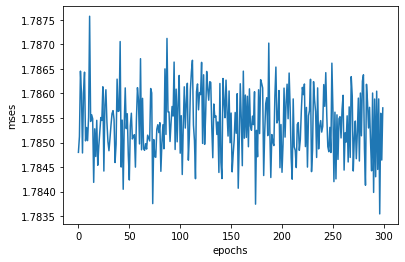

In [65]:
results_df = pd.DataFrame(list(zip(epochs, mses)),
               columns =['epochs', 'mses'])
sns.lineplot(data=results_df, x="epochs", y="mses")

## 5. Results


### 5.1 Vector size vs MSE for Matrix Factorization recommender system 

<AxesSubplot:xlabel='Vector_size', ylabel='mses'>

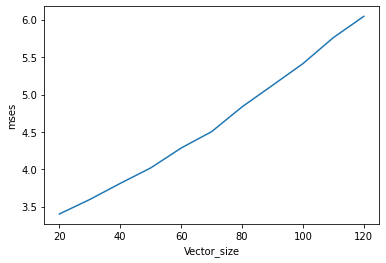

In [66]:
results_df = pd.DataFrame(list(zip(ks, errors)),
               columns =['Vector_size', 'mses'])
sns.lineplot(data=results_df, x="Vector_size", y="mses")

### 5.2 Vector size vs MSE for Hybrid Recommender System

<AxesSubplot:xlabel='Vector_size', ylabel='mses'>

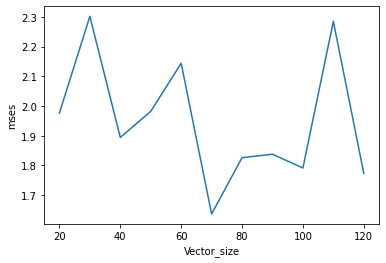

In [67]:
results_df_NN = pd.DataFrame(list(zip(vector_size, mses_v)),
               columns =['Vector_size', 'mses'])
sns.lineplot(data=results_df_NN, x="Vector_size", y="mses")

### 5.3 MSE for both recommender systems

<AxesSubplot:xlabel='Vector_size', ylabel='mses'>

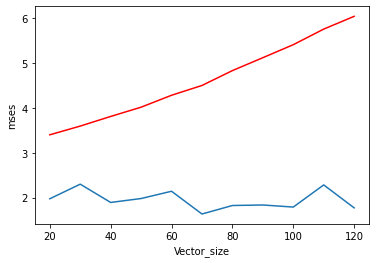

In [68]:
sns.lineplot(data=results_df, x='Vector_size', y='mses', color="red")
sns.lineplot(data=results_df_NN, x='Vector_size', y='mses')

### 5.4 Evaluation metrics 

Firts. we are going to extract the top 10 and 20 movies from the real dataset for the user_id 2. With that. we can compare the results of both of the recomender systems and calculate some evaluation metrics to display de performance of each system

In [75]:

real_top_20 = validation[validation.user_id == 1].sort_values(by=['rating'], ascending=False)[:20]
movies_id_top_20 = list(real_top_20['movie_id'])
real_top_20_np = real_top_20['rating'].to_numpy()
real_top_20_np_movies = real_top_20['movie_id'].to_numpy()
real_top_10 = real_top_20[:10]
real_top_10_movies = real_top_20_np_movies[:10]
real_top_10_np = real_top_10['rating'].to_numpy()
real_top_20

,rating,user_id,movie_id,sentiment_score,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western
82786,5,1,204,0.222046,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
96699,5,1,152,0.213083,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
88021,5,1,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74577,5,1,165,0.4843,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85557,5,1,19,0.30574,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75385,5,1,198,0.215182,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
77073,5,1,124,0.213847,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
88259,5,1,111,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
92487,5,1,172,0.150176,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
84793,5,1,207,0.27717,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


The predicted rating for the top 20 movies for the user_id 2 using the hybrid recomender system are the following:

In [76]:
npRecommend = real_top_20.to_numpy()
npRecommend[:,0] = myNN(torch.Tensor(npRecommend.astype(np.float32)[:,1:]).to(device)).to(device).cpu().detach().numpy().reshape(-1)
recomend_NN_df = pd.DataFrame(npRecommend,columns =['rating', 'user_id', 'movie_id', 'sentiment_score', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'sci_fi', 'Thriller', 'War', 'Western'])
recomend_NN_df['rating']=  recomend_NN_df['rating']*10
recomend_NN_top_20 = recomend_NN_df.sort_values(by=['rating'], ascending=False)
recomend_NN_top_20_np = recomend_NN_top_20['rating'].to_numpy()
recomend_NN_top_10 = recomend_NN_top_20[:10]
recomend_NN_top_10_np = recomend_NN_top_10['rating'].to_numpy()
recomend_NN_top_20

,rating,user_id,movie_id,sentiment_score,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western
19,5.19661,1,95,0.234822,0,0,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
0,5.07434,1,204,0.222046,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,5.073616,1,152,0.213083,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
7,5.068112,1,111,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
10,5.019627,1,59,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,5.003505,1,207,0.27717,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,4.998477,1,172,0.150176,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
13,4.987826,1,3,0.118717,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4.907952,1,165,0.4843,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.895645,1,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The predicted rating for the top 20 movies for the user_id 2 using the Matrix Factorization recommender system  are the following:

In [95]:
recomend_MF = nR_df.iloc[[0]].T
recomend_MF['movie_id'] = recomend_MF.index
recomend_MF = recomend_MF.reset_index(level=0)
recomend_MF_top_20 = recomend_MF[recomend_MF['movie_id'].isin(movies_id_top_20)]
recomend_MF_top_10 = recomend_MF_top_20[:10]
recomend_MF_top_20_np = recomend_MF_top_20[1].to_numpy()
recomend_MF_top_10_np = recomend_MF_top_10[1].to_numpy()
recomend_MF_top_20

,index,1,movie_id
2,3,3.326585,3
6,7,3.892415,7
12,13,3.596236,13
14,15,3.896167,15
18,19,4.343847,19
27,28,3.643997,28
51,52,3.642229,52
57,58,4.046320,58
58,59,4.580208,59
87,88,3.475050,88


In [96]:
real_top_20_np

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4])

In [97]:
recomend_NN_top_20_np

array([5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

Now, we can calculate some evaluation metrics such as RMSE,Precision, Recall, and F1-Score

#### MSE, RMSE


The mean of the squared difference between the data set's original and forecasted values is known as the mean squared error. It calculates the residuals' variance.

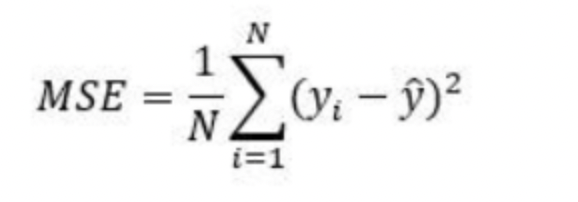

The square root of Mean Squared Error is called Root Mean Squared Error. It calculates the residuals' standard deviation.

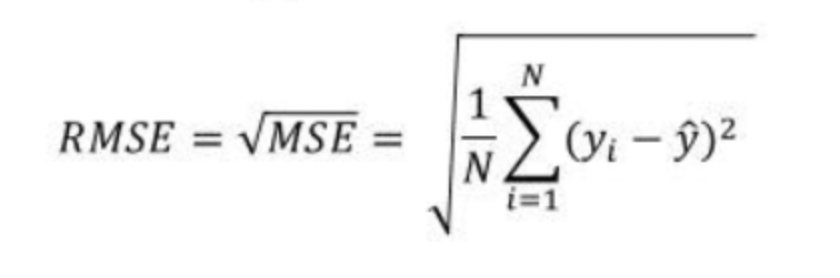

In [98]:
mse_top_20_MF = mean_squared_error(real_top_20_np, recomend_MF_top_20_np)
mse_top_10_MF = mean_squared_error(real_top_10_np, recomend_MF_top_10_np)
mse_top_20_NN = mean_squared_error(real_top_20_np, recomend_NN_top_20_np)
mse_top_10_NN = mean_squared_error(real_top_10_np, recomend_NN_top_10_np)

rmse_top_20_MF = np.sqrt(mean_squared_error(real_top_20_np, recomend_MF_top_20_np))
rmse_top_10_MF = np.sqrt(mean_squared_error(real_top_10_np, recomend_MF_top_10_np))
rmse_top_20_NN = np.sqrt(mean_squared_error(real_top_20_np, recomend_NN_top_20_np))
rmse_top_10_NN = np.sqrt(mean_squared_error(real_top_10_np, recomend_NN_top_10_np))
names = ['mse top 20 MF','mse top 10 MF','mse top 20 NN','mse top 10 NN','RMSE top 20 MF','RMSE top 10 MF','RMSE top 20 NN','RMSE top 10 NN']
rmse_df = pd.DataFrame([mse_top_20_MF,mse_top_10_MF,mse_top_20_NN,mse_top_10_NN,rmse_top_20_MF,rmse_top_10_MF,rmse_top_20_NN,rmse_top_10_NN],columns = ['rmse'])
rmse_df['names'] = names
print(f'MSE top 20 Matrix Factorization: {mse_top_20_MF}')
print(f'MSE top 10 Matrix Factorization: {mse_top_10_MF}')
print(f'MSE top 20 Hybrid Recomender: {mse_top_20_NN}')
print(f'MSE top 10 Hybrid Recomender: {mse_top_10_NN}')

print(f'RMSE top 20 Matrix Factorization: {rmse_top_20_MF}')
print(f'RMSE top 10 Matrix Factorization: {rmse_top_10_MF}')
print(f'RMSE top 20 Hybrid Recomender: {rmse_top_20_NN}')
print(f'RMSE top 10 Hybrid Recomender: {rmse_top_10_NN}')

MSE top 20 Matrix Factorization: 0.9834065270090901
MSE top 10 Matrix Factorization: 1.4740088849834634
MSE top 20 Hybrid Recomender: 0.35
MSE top 10 Hybrid Recomender: 0.4
RMSE top 20 Matrix Factorization: 0.9916685570335938
RMSE top 10 Matrix Factorization: 1.214087675986979
RMSE top 20 Hybrid Recomender: 0.5916079783099616
RMSE top 10 Hybrid Recomender: 0.6324555320336759


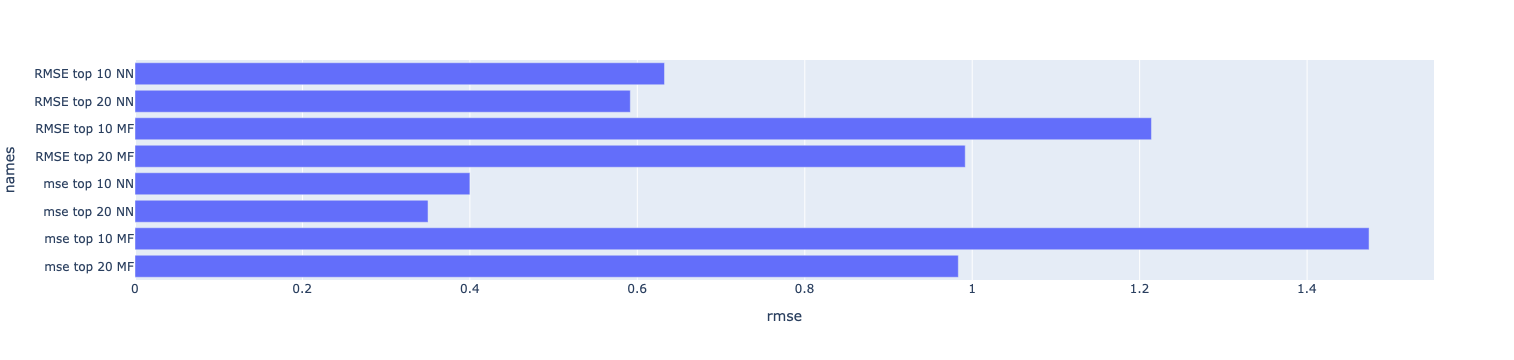

In [99]:
import plotly.express as px

fig = px.bar(rmse_df, x='rmse',y = 'names')
fig.show()

#### Precision

We can define precision as the ratio tp/(tp+fp). tp is the bumber of true positives and fp the number of false positives.Intuitively, the classifier's precision is its capacity not to classify a negative sample as positive. 

1 is the best value, while 0 is the worst.

In [269]:

npRecommend = full_df_clean[full_df_clean['user_id']==2].to_numpy()
npRecommend[:,0] = myNN(torch.Tensor(npRecommend.astype(np.float32)[:,1:]).to(device)).to(device).cpu().detach().numpy().reshape(-1)
recomend_NN_df = pd.DataFrame(npRecommend,columns =['rating', 'user_id', 'movie_id', 'sentiment_score', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'sci_fi', 'Thriller', 'War', 'Western'])
recomend_NN_df['rating']=  recomend_NN_df['rating']*10
recomend_NN_top_20 = recomend_NN_df.sort_values(by=['rating'], ascending=False)[:20]
recomend_NN_top_20_np = recomend_NN_top_20['movie_id'].to_numpy()
recomend_NN_top_10 = recomend_NN_top_20[:10]
recomend_NN_top_10_np = recomend_NN_top_10['movie_id'].to_numpy()
recomend_NN_top_20

,rating,user_id,movie_id,sentiment_score,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western
52,4.865166,2,285,-0.19374,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,4.752045,2,10,0.25361,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
26,4.751604,2,295,0.048236,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
27,4.747361,2,242,-0.01544,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
46,4.724413,2,284,0.217781,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
45,4.703988,2,255,0.34787,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
17,4.701394,2,313,0.123018,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
55,4.69637,2,272,0.243833,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.695504,2,314,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28,4.674945,2,283,0.115214,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [101]:
recomend_MF = nR_df.iloc[[0]].T
recomend_MF['movie_id'] = recomend_MF.index
recomend_MF = recomend_MF.reset_index(level=0)
recomend_MF_top_20 = recomend_MF.sort_values(by=[1], ascending=False)[:20]
recomend_MF_top_10 = recomend_MF_top_20[:10]
recomend_MF_top_20_np = recomend_MF_top_20['movie_id'].to_numpy()
recomend_MF_top_10_np = recomend_MF_top_10['movie_id'].to_numpy()
recomend_MF_top_20

,index,1,movie_id
1499,1500,5.228070,1500
1542,1543,5.219748,1543
1018,1019,5.210295,1019
1561,1562,5.086904,1562
1640,1641,5.074150,1641
1575,1576,4.994967,1576
118,119,4.988635,119
168,169,4.935269,169
1650,1651,4.934709,1651
97,98,4.898610,98


In [103]:
recomend_MF_top_20[1] = recomend_MF_top_20[1].apply(lambda x: int(x))
recomend_MF_top_10 = recomend_MF_top_20[:10]
recomend_MF_top_20_np = recomend_MF_top_20[1].to_numpy()
recomend_MF_top_10_np = recomend_MF_top_10[1].to_numpy()
recomend_MF_top_20

,index,1,movie_id
1499,1500,5,1500
1542,1543,5,1543
1018,1019,5,1019
1561,1562,5,1562
1640,1641,5,1641
1575,1576,4,1576
118,119,4,119
168,169,4,169
1650,1651,4,1651
97,98,4,98


In [104]:
recomend_NN_top_20['rating']= recomend_NN_top_20['rating'].apply(lambda x: int(x))
recomend_NN_top_10 = recomend_NN_top_20[:10]
recomend_NN_top_20_np = recomend_NN_top_20['rating'].to_numpy()
recomend_NN_top_10_np = recomend_NN_top_10['rating'].to_numpy()
recomend_NN_top_20

,rating,user_id,movie_id,sentiment_score,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-noir,Horror,Musical,Mystery,Romance,sci_fi,Thriller,War,Western
19,5,1,95,0.234822,0,0,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
0,5,1,204,0.222046,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,5,1,152,0.213083,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
7,5,1,111,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
10,5,1,59,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,5,1,207,0.27717,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,4,1,172,0.150176,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
13,4,1,3,0.118717,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,1,165,0.4843,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
real_top_20_np_movies = real_top_20['rating'].to_numpy()
real_top_10_np_movies = real_top_20_np_movies[:10]
real_top_20_np_movies

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4])

Using the 'micro' parameter, the function will calculate metrics globally by counting the total true positives, false negatives and false positives.
When true positive + false positive == 0, the functino will return 0 and raises UndefinedMetricWarning. This behavior can be modified with zero_division

In [130]:
from sklearn.metrics import precision_score

precision_MF_top_20 = precision_score(real_top_20_np_movies, recomend_MF_top_20_np, average='micro')
precision_NN_top_20 = precision_score(real_top_20_np_movies, recomend_NN_top_20_np,average='micro')
precision_MF_top_10 = precision_score(real_top_10_np_movies, recomend_MF_top_10_np,average='micro')
precision_NN_top_10 = precision_score(real_top_10_np_movies, recomend_NN_top_10_np,average='micro')
precision = [precision_MF_top_20,precision_NN_top_20,precision_MF_top_10,precision_NN_top_10]
names = ['precision_MF_top_20','precision_NN_top_20','precision_MF_top_10','precision_NN_top_10']
precision_df = pd.DataFrame(precision,columns = ['precision'])
precision_df['names'] = names
print(f'precision_MF_top_20: {precision_MF_top_20}')
print(f'precision_NN_top_20: {precision_NN_top_20}')
print(f'precision_MF_top_10: {precision_MF_top_10}')
print(f'precision_NN_top_10: {precision_NN_top_10}')

precision_MF_top_20: 0.6
precision_NN_top_20: 0.65
precision_MF_top_10: 0.5
precision_NN_top_10: 0.6


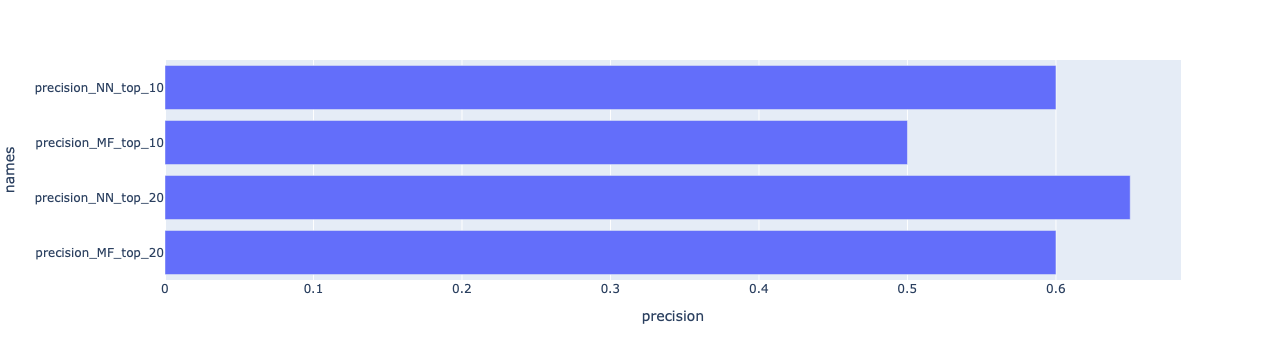

In [131]:
fig = px.bar(precision_df, x='precision',y = 'names')
fig.show()

#### Recall

The classifier's capacity to locate all the positive samples is known as recall. We can define recall as the ration of tp / (tp + fn) where fn is the quantity of false negatives and tp the number of true positives

1 is the best value, while 0 is the worst.

In [154]:
from sklearn.metrics import recall_score

recall_MF_top_20 = recall_score(real_top_20_np_movies, recomend_MF_top_20_np, average='micro',zero_division=1)
recall_NN_top_20 = recall_score(real_top_20_np_movies, recomend_NN_top_20_np,average='micro',zero_division=1)
recall_MF_top_10 = recall_score(real_top_10_np_movies, recomend_MF_top_10_np,average='micro',zero_division=1)
recall_NN_top_10 = recall_score(real_top_10_np_movies, recomend_NN_top_10_np,average='micro',zero_division=1)
recall = [recall_MF_top_20,recall_NN_top_20,recall_MF_top_10,recall_NN_top_10]
names = ['recall_MF_top_20','recall_NN_top_20','recall_MF_top_10','recall_NN_top_10']
recall_df = pd.DataFrame(recall,columns = ['recall'])
recall_df['names'] = names
print(f'recall_MF_top_20: {recall_MF_top_20}')
print(f'recall_NN_top_20: {recall_NN_top_20}')
print(f'recall_MF_top_10: {recall_MF_top_10}')
print(f'recall_NN_top_10: {recall_NN_top_10}')

recall_MF_top_20: 0.6
recall_NN_top_20: 0.65
recall_MF_top_10: 0.5
recall_NN_top_10: 0.6


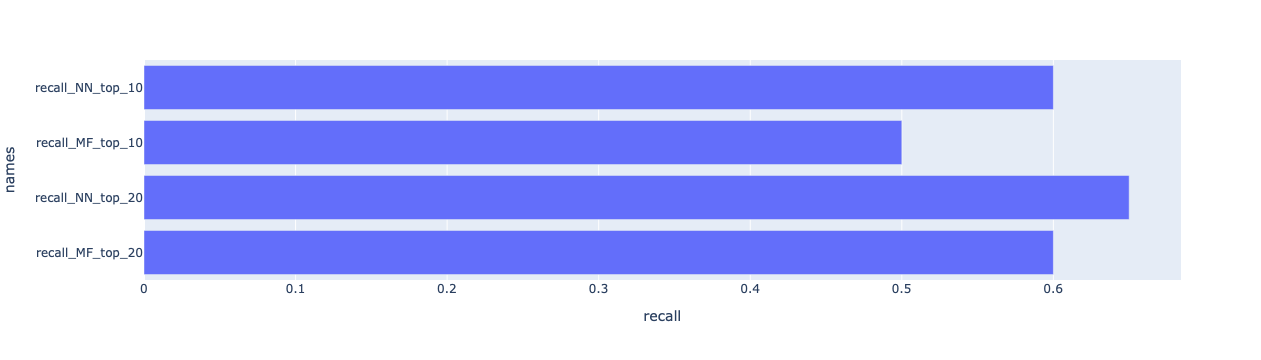

In [156]:
fig = px.bar(recall_df, x='recall',y = 'names')
fig.show()

#### F1-Score

The F1 score can be thought of as a harmonic mean of precision and recall, with the best value being 1 and the poorest being 0. Precision and recall both contribute equally in terms of percentage to the F1 score. We can calculate the F1 score with the formula: 
F1 = 2 * (precision * recall) / (precision + recall)

In [157]:
from sklearn.metrics import f1_score
f1_MF_top_20 = f1_score(real_top_20_np_movies, recomend_MF_top_20_np, average='micro',zero_division=1)
f1_NN_top_20 = f1_score(real_top_20_np_movies, recomend_NN_top_20_np,average='micro',zero_division=1)
f1_MF_top_10 = f1_score(real_top_10_np_movies, recomend_MF_top_10_np,average='micro',zero_division=1)
f1_NN_top_10 = f1_score(real_top_10_np_movies, recomend_NN_top_10_np,average='micro',zero_division=1)
f1 = [f1_MF_top_20,f1_NN_top_20,f1_MF_top_10,f1_NN_top_10]
names = ['f1_MF_top_20','f1_NN_top_20','f1_MF_top_10','f1_NN_top_10']
f1_df = pd.DataFrame(f1,columns = ['f1'])
f1_df['names'] = names
print(f'f1_MF_top_20: {f1_MF_top_20}')
print(f'f1_NN_top_20: {f1_NN_top_20}')
print(f'f1_MF_top_10: {f1_MF_top_10}')
print(f'f1_NN_top_10: {f1_NN_top_10}')

f1_MF_top_20: 0.6
f1_NN_top_20: 0.65
f1_MF_top_10: 0.5
f1_NN_top_10: 0.6


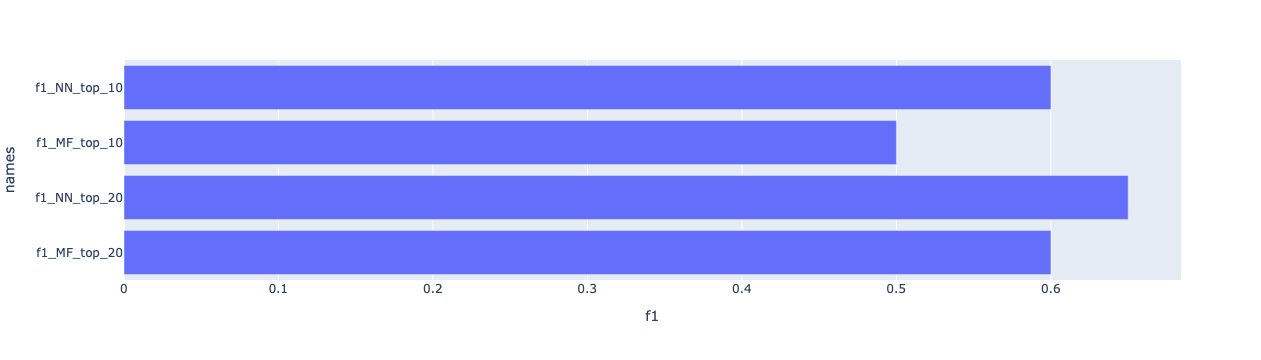

In [158]:
fig = px.bar(f1_df, x='f1',y = 'names')
fig.show()